# ABC2026 – Notebook 2  
## Basic Preprocessing & Visualization (EEG, EMG, IMU)

This notebook demonstrates a **basic preprocessing workflow** for MindRove biosignals:

- Loading structured data produced in Notebook 1  
- Applying **simple filters** to EEG and EMG using `scipy.signal`  
- Visualizing:
  - EEG before vs after filtering (one trial, one channel)
  - EMG envelopes with **mean ± standard deviation** across trials
  - Raw IMU signals (for inspection only)

> **Important:**  
> Only *fundamental* preprocessing steps are shown here:
> - **50 Hz notch filter**  
> - **Band-pass filters** (1–40 Hz for EEG, 50–240 Hz for EMG)  
> - **Rectification and envelope extraction** (EMG)
>

> Participants are encouraged to add further preprocessing steps **based on the characteristics of the signals and the requirements of the analysis**.



In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **SECTION 1 - Imports, paths, and save toggles**

In [2]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal

# -----------------------------
# Paths (adjust if needed)
# -----------------------------
STRUCTURED_ROOT   = "/content/drive/MyDrive/MindRove_Data/structured_data"
PREPROCESSED_ROOT = "/content/drive/MyDrive/MindRove_Data/preprocessed"

FS = 500  # Hz (sampling rate for all signals)

# Choose which subject to work with
SUBJECT_ID = "S04"   # <- change if needed (e.g., "S01", "S02", ...)

# -----------------------------
# Saving options
# -----------------------------
SAVE_EEG = False   # Save filtered EEG? (we only visualize raw/filterd here)
SAVE_EMG = True    # Save filtered EMG for ML? (we are going to use EMG data for the next tutorial)
SAVE_IMU = False   # Save IMU outputs? (we only visualize raw here)

print("STRUCTURED_ROOT  :", STRUCTURED_ROOT)
print("PREPROCESSED_ROOT:", PREPROCESSED_ROOT)
print("SUBJECT_ID       :", SUBJECT_ID)



STRUCTURED_ROOT  : /content/drive/MyDrive/MindRove_Data/structured_data
PREPROCESSED_ROOT: /content/drive/MyDrive/MindRove_Data/preprocessed
SUBJECT_ID       : S04


## **Helpers: subject listing & trial name extraction**

In [3]:
def list_subjects(structured_root):
    if not os.path.exists(structured_root):
        return []
    return sorted([d for d in os.listdir(structured_root)
                   if d.startswith("S") and os.path.isdir(os.path.join(structured_root, d))])

def get_subject_device_dir(subject_id):
    return os.path.join(STRUCTURED_ROOT, subject_id, "by_device")

def extract_clean_trial_id_from_structured(filename):
    base = os.path.splitext(filename)[0]
    parts = base.split("_")
    return parts[0] + "_" + parts[1]  # S04_T01


## **Filter helper functions (SciPy)**

In [4]:
def design_notch_filter(fs, f0=50.0, Q=30.0):
    return signal.iirnotch(w0=f0, Q=Q, fs=fs)

def design_bandpass_filter(fs, lowcut, highcut, order=4):
    ny = fs / 2
    if highcut >= ny:
        highcut = ny - 1
    return signal.butter(order, [lowcut, highcut], btype="bandpass", fs=fs)

def design_lowpass_filter(fs, cutoff, order=4):
    return signal.butter(order, cutoff, btype="lowpass", fs=fs)

def apply_filter(b, a, sig):
    return signal.filtfilt(b, a, sig)


### **SECTION 2 – EEG Demo (basic filters, no saving by default)**

## **Load and filter EEG channels**

In [5]:
device_dir = get_subject_device_dir(SUBJECT_ID)
eeg_files = sorted(glob.glob(os.path.join(device_dir, f"{SUBJECT_ID}_T*_EEG_1_raw.csv")))
print("Found EEG files:", len(eeg_files))

eeg_demo_raw = None
eeg_demo_filt = None

if eeg_files:
    # Design filters
    b_notch, a_notch = design_notch_filter(FS)
    b_bp, a_bp       = design_bandpass_filter(FS, 1.0, 40.0)

    eeg_out = os.path.join(PREPROCESSED_ROOT, SUBJECT_ID, "EEG")
    if SAVE_EEG:
        os.makedirs(eeg_out, exist_ok=True)

    for i, ep in enumerate(eeg_files):
        fname = os.path.basename(ep)
        trial_id = extract_clean_trial_id_from_structured(fname)

        df = pd.read_csv(ep)
        eeg_cols = [c for c in df.columns if c.startswith("Channel")]
        ts = df["Timestamp"].to_numpy(float)

        filtered = {"Timestamp": ts}

        for ch in eeg_cols:
            raw = df[ch].to_numpy(float)
            notched  = apply_filter(b_notch, a_notch, raw)
            filtered_sig = apply_filter(b_bp, a_bp, notched)
            filtered[ch + "_filtered"] = filtered_sig

            if i == 0 and ch == "Channel1":
                eeg_demo_raw = raw
                eeg_demo_filt = filtered_sig
                eeg_t = np.arange(len(raw)) / FS

        if SAVE_EEG:
            outname = f"{trial_id}_EEG_1_filtered.csv"
            pd.DataFrame(filtered).to_csv(os.path.join(eeg_out, outname), index=False)
            print("Saved:", outname)
else:
    print("No EEG to process.")



Found EEG files: 34


## **EEG visualization: raw vs filtered (one channel/one trial)**

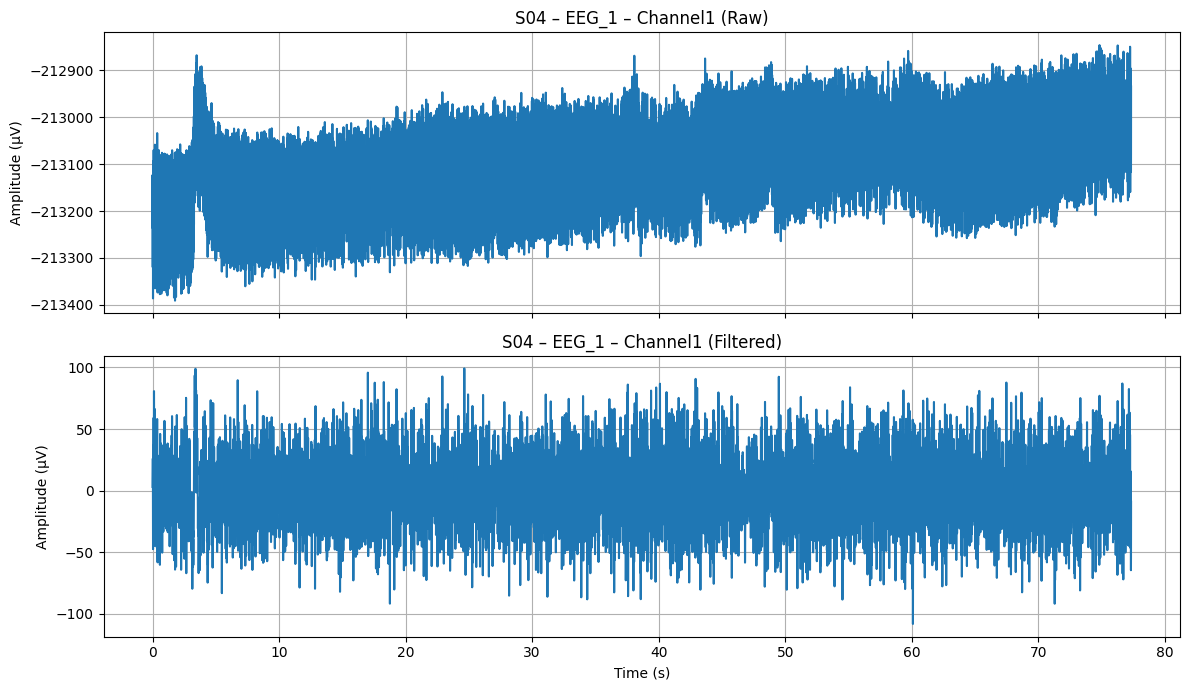

In [6]:
if eeg_demo_raw is not None:
    fig, ax = plt.subplots(2,1, figsize=(12,7), sharex=True)

    ax[0].plot(eeg_t, eeg_demo_raw)
    ax[0].set_title(f"{SUBJECT_ID} – EEG_1 – Channel1 (Raw)")
    ax[0].set_ylabel("Amplitude (µV)")
    ax[0].grid(True)

    ax[1].plot(eeg_t, eeg_demo_filt)
    ax[1].set_ylabel("Amplitude (µV)")
    ax[1].set_title(f"{SUBJECT_ID} – EEG_1 – Channel1 (Filtered)")
    ax[1].set_xlabel("Time (s)")
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


## **SECTION 3 – EMG Preprocessing (rectification + envelope + mean±std)**

## **EMG filtering (all channels, all EMG devices)**

We’ll process all EMG devices, e.g. EMG_2, EMG_3, but use EMG_2 Channel1 for the envelope visualization.

In [7]:
emg_devices = ["EMG_2", "EMG_3"]

env_list = []
min_len_env = None

# Filters
b_notch_emg, a_notch_emg = design_notch_filter(FS)
b_bp_emg, a_bp_emg       = design_bandpass_filter(FS, 50.0, 240.0)
b_lp_env, a_lp_env       = design_lowpass_filter(FS, 10.0)

for dev in emg_devices:
    pattern = os.path.join(device_dir, f"{SUBJECT_ID}_T*_{dev}_raw.csv")
    files = sorted(glob.glob(pattern))

    print(f"\n{dev}: {len(files)} files")

    # Create subfolder
    dev_out = os.path.join(PREPROCESSED_ROOT, SUBJECT_ID, "EMG", dev)
    if SAVE_EMG:
        os.makedirs(dev_out, exist_ok=True)

    for fp in files:
        fname = os.path.basename(fp)
        trial_id = extract_clean_trial_id_from_structured(fname)

        df = pd.read_csv(fp)
        emg_cols = [c for c in df.columns if c.startswith("Channel")]
        ts = df["Timestamp"].to_numpy(float)

        filtered = {"Timestamp": ts}

        for ch in emg_cols:
            raw = df[ch].to_numpy(float)
            notched  = apply_filter(b_notch_emg, a_notch_emg, raw)
            filt_sig = apply_filter(b_bp_emg, a_bp_emg, notched)
            filtered[ch + "_filtered"] = filt_sig

            # Envelope for visualization (EMG_2 Channel1)
            if dev == "EMG_2" and ch == "Channel1":
                rect = np.abs(filt_sig)
                env = apply_filter(b_lp_env, a_lp_env, rect)

                if min_len_env is None or len(env) < min_len_env:
                    min_len_env = len(env)

                env_list.append(env)

        if SAVE_EMG:
            outname = f"{trial_id}_{dev}_filtered.csv"
            pd.DataFrame(filtered).to_csv(os.path.join(dev_out, outname), index=False)
            print("Saved:", outname)

# Align envelopes
if env_list:
    env_aligned = np.stack([e[:min_len_env] for e in env_list])
else:
    env_aligned = None



EMG_2: 34 files
Saved: S04_T01_EMG_2_filtered.csv
Saved: S04_T02_EMG_2_filtered.csv
Saved: S04_T03_EMG_2_filtered.csv
Saved: S04_T04_EMG_2_filtered.csv
Saved: S04_T05_EMG_2_filtered.csv
Saved: S04_T06_EMG_2_filtered.csv
Saved: S04_T07_EMG_2_filtered.csv
Saved: S04_T08_EMG_2_filtered.csv
Saved: S04_T09_EMG_2_filtered.csv
Saved: S04_T10_EMG_2_filtered.csv
Saved: S04_T11_EMG_2_filtered.csv
Saved: S04_T12_EMG_2_filtered.csv
Saved: S04_T13_EMG_2_filtered.csv
Saved: S04_T14_EMG_2_filtered.csv
Saved: S04_T15_EMG_2_filtered.csv
Saved: S04_T16_EMG_2_filtered.csv
Saved: S04_T17_EMG_2_filtered.csv
Saved: S04_T18_EMG_2_filtered.csv
Saved: S04_T19_EMG_2_filtered.csv
Saved: S04_T20_EMG_2_filtered.csv
Saved: S04_T21_EMG_2_filtered.csv
Saved: S04_T22_EMG_2_filtered.csv
Saved: S04_T23_EMG_2_filtered.csv
Saved: S04_T24_EMG_2_filtered.csv
Saved: S04_T25_EMG_2_filtered.csv
Saved: S04_T26_EMG_2_filtered.csv
Saved: S04_T27_EMG_2_filtered.csv
Saved: S04_T28_EMG_2_filtered.csv
Saved: S04_T29_EMG_2_filtered.c

## **EMG stacked mean ± std  plot**

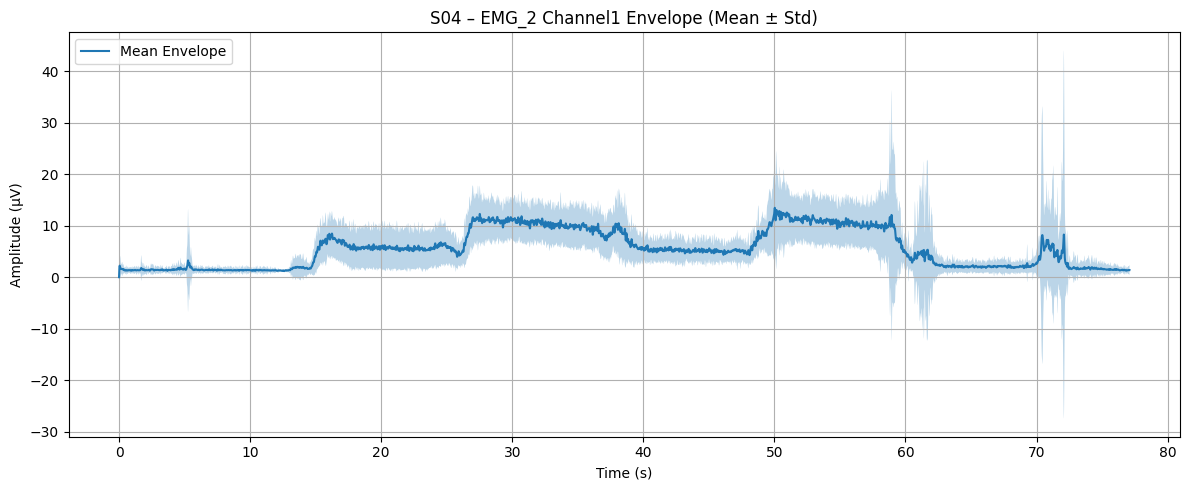

In [11]:
if env_aligned is not None:
    t_env = np.arange(env_aligned.shape[1]) / FS
    mean_env = env_aligned.mean(axis=0)
    std_env  = env_aligned.std(axis=0)

    plt.figure(figsize=(12,5))
    plt.plot(t_env, mean_env, label="Mean Envelope")
    plt.fill_between(t_env, mean_env - std_env, mean_env + std_env, alpha=0.3)
    plt.title(f"{SUBJECT_ID} – EMG_2 Channel1 Envelope (Mean ± Std)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## **SECTION 4 – IMU raw visualization**

In [9]:
imu_devices = ["IMU_1", "IMU_2", "IMU_3"]
imu_demo = None

for dev in imu_devices:
    pattern = os.path.join(device_dir, f"{SUBJECT_ID}_T*_{dev}_raw.csv")
    files = sorted(glob.glob(pattern))

    print(f"\n{dev}: {len(files)} files")

    dev_out = os.path.join(PREPROCESSED_ROOT, SUBJECT_ID, "IMU", dev)
    if SAVE_IMU:
        os.makedirs(dev_out, exist_ok=True)

    for i, fp in enumerate(files):
        fname = os.path.basename(fp)
        trial_id = extract_clean_trial_id_from_structured(fname)

        df = pd.read_csv(fp)

        if SAVE_IMU:
            outname = f"{trial_id}_{dev}_raw_copy.csv"
            df.to_csv(os.path.join(dev_out, outname), index=False)
            print("Saved:", outname)

        if dev == "IMU_1" and imu_demo is None:
            imu_demo = df



IMU_1: 34 files

IMU_2: 34 files

IMU_3: 34 files


## **Plot raw IMU (Gyro + Acc)**

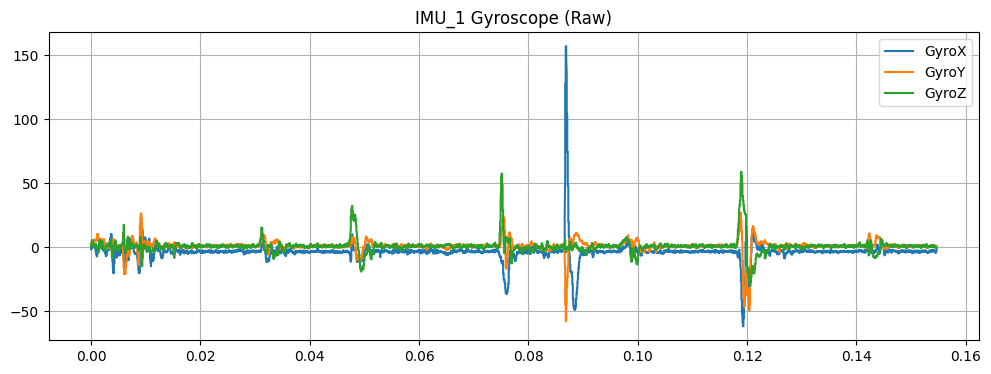

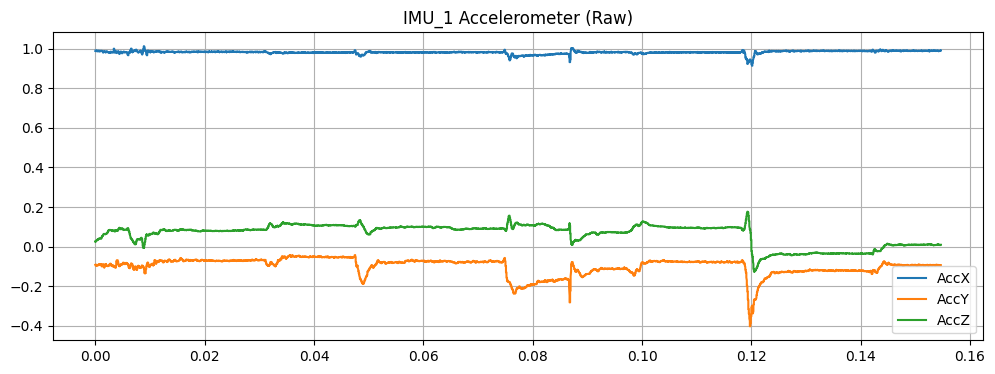

In [10]:
if imu_demo is not None:
    ts = imu_demo["Timestamp"].to_numpy(float)
    t = (ts - ts[0]) / FS

    plt.figure(figsize=(12,4))
    plt.plot(t, imu_demo["GyroX"], label="GyroX")
    plt.plot(t, imu_demo["GyroY"], label="GyroY")
    plt.plot(t, imu_demo["GyroZ"], label="GyroZ")
    plt.title("IMU_1 Gyroscope (Raw)")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(t, imu_demo["AccX"], label="AccX")
    plt.plot(t, imu_demo["AccY"], label="AccY")
    plt.plot(t, imu_demo["AccZ"], label="AccZ")
    plt.title("IMU_1 Accelerometer (Raw)")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("No IMU_1 demo file found.")
